# US Freight Industry

This is the final project for the Data Science course by Cambridge ICU, delivered by Flatiron School. In this project, I will use the datasets, Freight Analysis Framework Version 5 (FAF5) and Bureau of Transportation Statistics dataset.

The [Freight Analysis Framework (FAF)](https://faf.ornl.gov/faf5/), produced through a partnership between BTS and FHWA, integrates data from various sources to create a comprehensive picture of freight movement among states and major metropolitan areas by all modes of transportation. The 2017 Commodity Flow Survey (CFS) and international trade data from the Census Bureau serve as the backbone of FAF and are integrated with ancillary data sources that capture goods movement in agriculture, resource extraction, utility, construction, retail, services, and other sectors.

[Freight Facts and Figures](https://www.bts.gov/product/freight-facts-and-figures), developed by the Bureau of Transportation Statistics, is a collection of charts and statistical tables about freight transportation in the United States.

## Import Libraries

I'll import the libraries I need for data cleaning, manipulation and visualization.

In [606]:
import numpy as np
import pandas as pd
import random
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from itertools import chain

## Import Dataset

I'll import the main dataset and take a look at the columns. Please download the dataset from the FAF5 website if you haven't already. I have not uploaded it to Github becasue of the file size.

In [607]:
regions_df = pd.read_csv('FAF5.3.csv', dtype = {'dms_orig': str, 'dms_dest': str})
regions_df.columns

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050'],
      dtype='object')

From the main dataframe, we can separate imports/exports using fr_dest and fr_orig. `fr_dest` stands for foreign region of shipment destination. `fr_orig` stands for foreign region of shipment origin.

In [608]:
# domestic destination
dom_dest_df = regions_df.loc[pd.isnull(regions_df['fr_dest'])]

# domestic origin
dom_origin_df = regions_df.loc[pd.isnull(regions_df['fr_orig'])]

## Setup Variables and Dictionaries

The list of commodities is obtained from the FAF5 metadata file.

In [609]:
com_df = pd.read_csv('FAF5_commodities.csv')
com_list = commodities_df['Description']

com_dict = {}
for i in range(1, len(com_list)+1):
    com_dict[i] = com_list[i-1]

com_dict[99] = 'Commodity Unknown'
com_dict[43] = 'Mixed freight'
# com_dict # Uncomment line to view the list of commodities / com_list

In [610]:
# dictionary of foreign trading partners
# fr_dict = {801: "Canada", 802: "Mexico", 803: "Rest of Americas", 804: "Europe", 805: "Africa",
#            806: "SW & Central Asia", 807: "Eastern Asia", 808: "SE Asia & Oceania",
#            'total': "Total"}

# List of modes
mode_list = ["Truck", "Rail", "Water", "Air", "Multimode and mail", "Pipeline", "Other/unknown"]

# List of years
years = ['2017', '2018', '2019','2020','2022', '2023', '2025', '2030', '2035', '2040', '2045', '2050']

## Production and Consumption of Commodities

To get an yearly chart of commodities by productio and consumption, we will create two dataframes based on commodities moving towards origin and destination.

In [611]:
goodsAndYearsCols = ['sctg2','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

# origin dataframe
dom_origin_comm_df = dom_origin_df[goodsAndYearsCols].groupby('sctg2', as_index = False).sum()
dom_origin_comm_df.columns = ['sctg2'] + years
dom_origin_comm_df.loc['total'] = dom_origin_comm_df.sum()

# destination dataframe
dom_dest_comm_df = dom_dest_df[goodsAndYearsCols].groupby('sctg2', as_index = False).sum()
dom_dest_comm_df.columns = ['sctg2'] + years
dom_dest_comm_df.loc['total'] = dom_dest_comm_df.sum()

## Top Commodities by Destination and Origin

This will give us the production and consumption of top commodities over the years.

In [612]:
top_10_dest_2017 = dom_dest_comm_df[['sctg2','2017','2050']].sort_values('2017', axis = 0, ascending = False).head(11)
top_10_dest_2017.drop('total', inplace = True)

top_10_dest_2050 = dom_dest_comm_df[['sctg2','2017','2050']].sort_values('2050', axis = 0, ascending = False).head(11)
top_10_dest_2050.drop('total', inplace = True)

top_2017_dest = top_10_dest_2017['sctg2'].values.flatten().tolist()
top_2050_dest = top_10_dest_2050['sctg2'].values.flatten().tolist()
top_dest_list = [x for x in top_2017_dest or top_2050_dest]

top_dest_2017_2050 = dom_dest_comm_df.loc[dom_dest_comm_df['sctg2'].isin(top_dest_list), ['sctg2']+years]
top_dest_2017_2050.reset_index(inplace = True, drop = True)
top_dest_2017_2050['Commodity'] = top_dest_2017_2050['sctg2'].apply(lambda x: com_dict[x])

In [614]:
top_10_origin_2017 = dom_origin_comm_df[['sctg2','2017','2050']].sort_values('2017', axis = 0, ascending = False).head(11)
top_10_origin_2017.drop('total', inplace = True)

top_10_origin_2050 = dom_origin_comm_df[['sctg2','2017','2050']].sort_values('2050', axis = 0, ascending = False).head(11)
top_10_origin_2050.drop('total', inplace = True)

top_2017_origin = top_10_origin_2017['sctg2'].values.flatten().tolist()
top_2050_origin = top_10_origin_2050['sctg2'].values.flatten().tolist()
top_origin_list = [x for x in top_2017_origin or top_2050_origin]

top_origin_2017_2050 = dom_origin_comm_df.loc[dom_origin_comm_df['sctg2'].isin(top_origin_list),  ['sctg2'] + years]
top_origin_2017_2050.reset_index(inplace = True, drop = True)
top_origin_2017_2050['Commodity'] = top_origin_2017_2050['sctg2'].apply(lambda x: com_dict[x])

## Plotting Function

We want to see a trend of each commodity over time. Creating multiple subplots is one way we can do it.

In [618]:
def plotCommodities(df, years, gridSize, title, xlabels, ylabels):
    fig, ax = plt.subplots(nrows=gridSize[0], ncols=gridSize[1], figsize=(15,15))
    fig.set_figheight(25)
    fig.set_figwidth(25)
    
    currentRow = 0
    
    for row in ax:
        for col in row:
            if(currentRow < df.shape[0]):
                col.plot(years, df.iloc[currentRow, 1:13])
                col.set_title(df.iloc[currentRow, 13])
                col.set(xlabel=xlabels, ylabel=ylabels)
                currentRow = currentRow + 1
    
    
    plt.suptitle(title,fontsize=20)

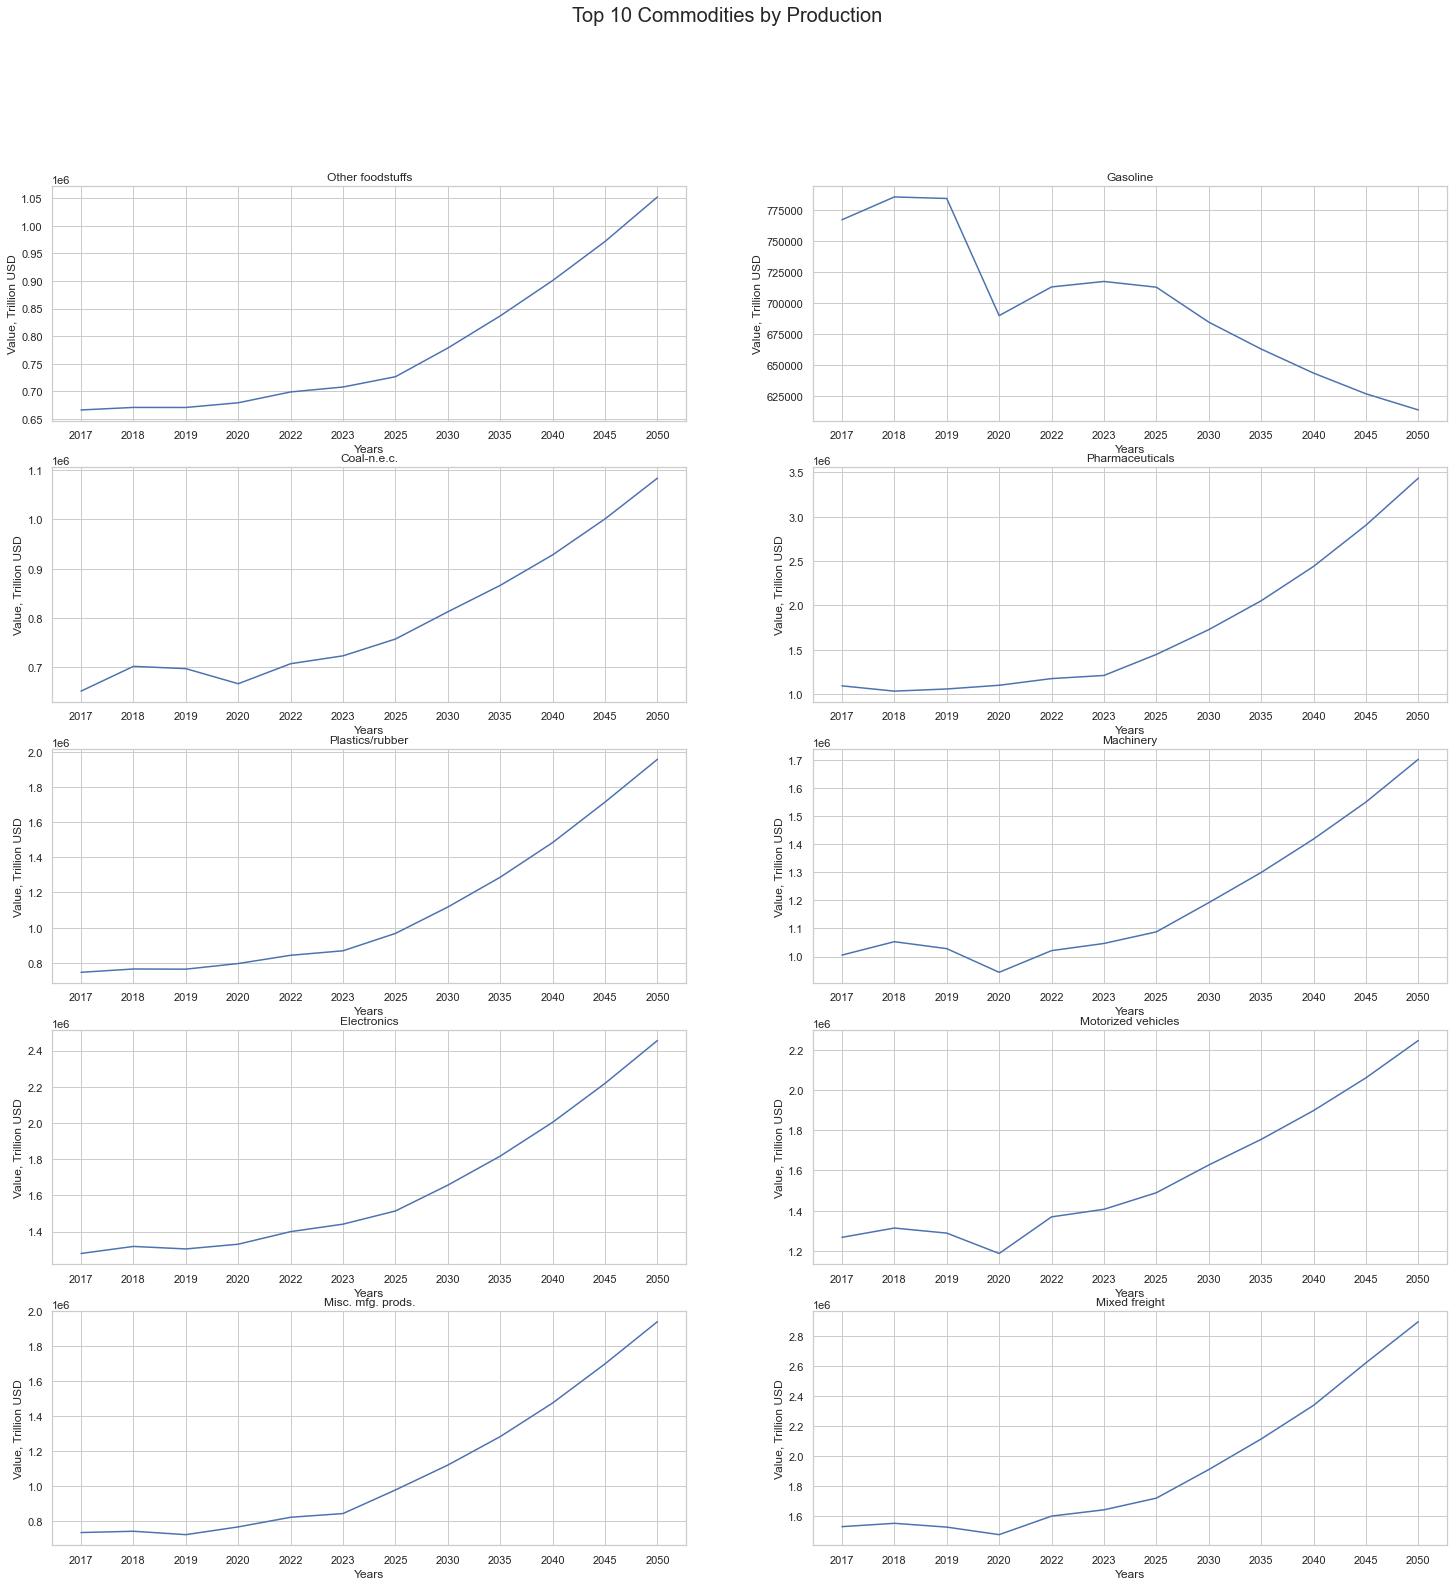

In [616]:
plotCommodities(top_origin_2017_2050, years, (5, 2), 'Top 10 Commodities by Production', "Years", "Value, Trillion USD")

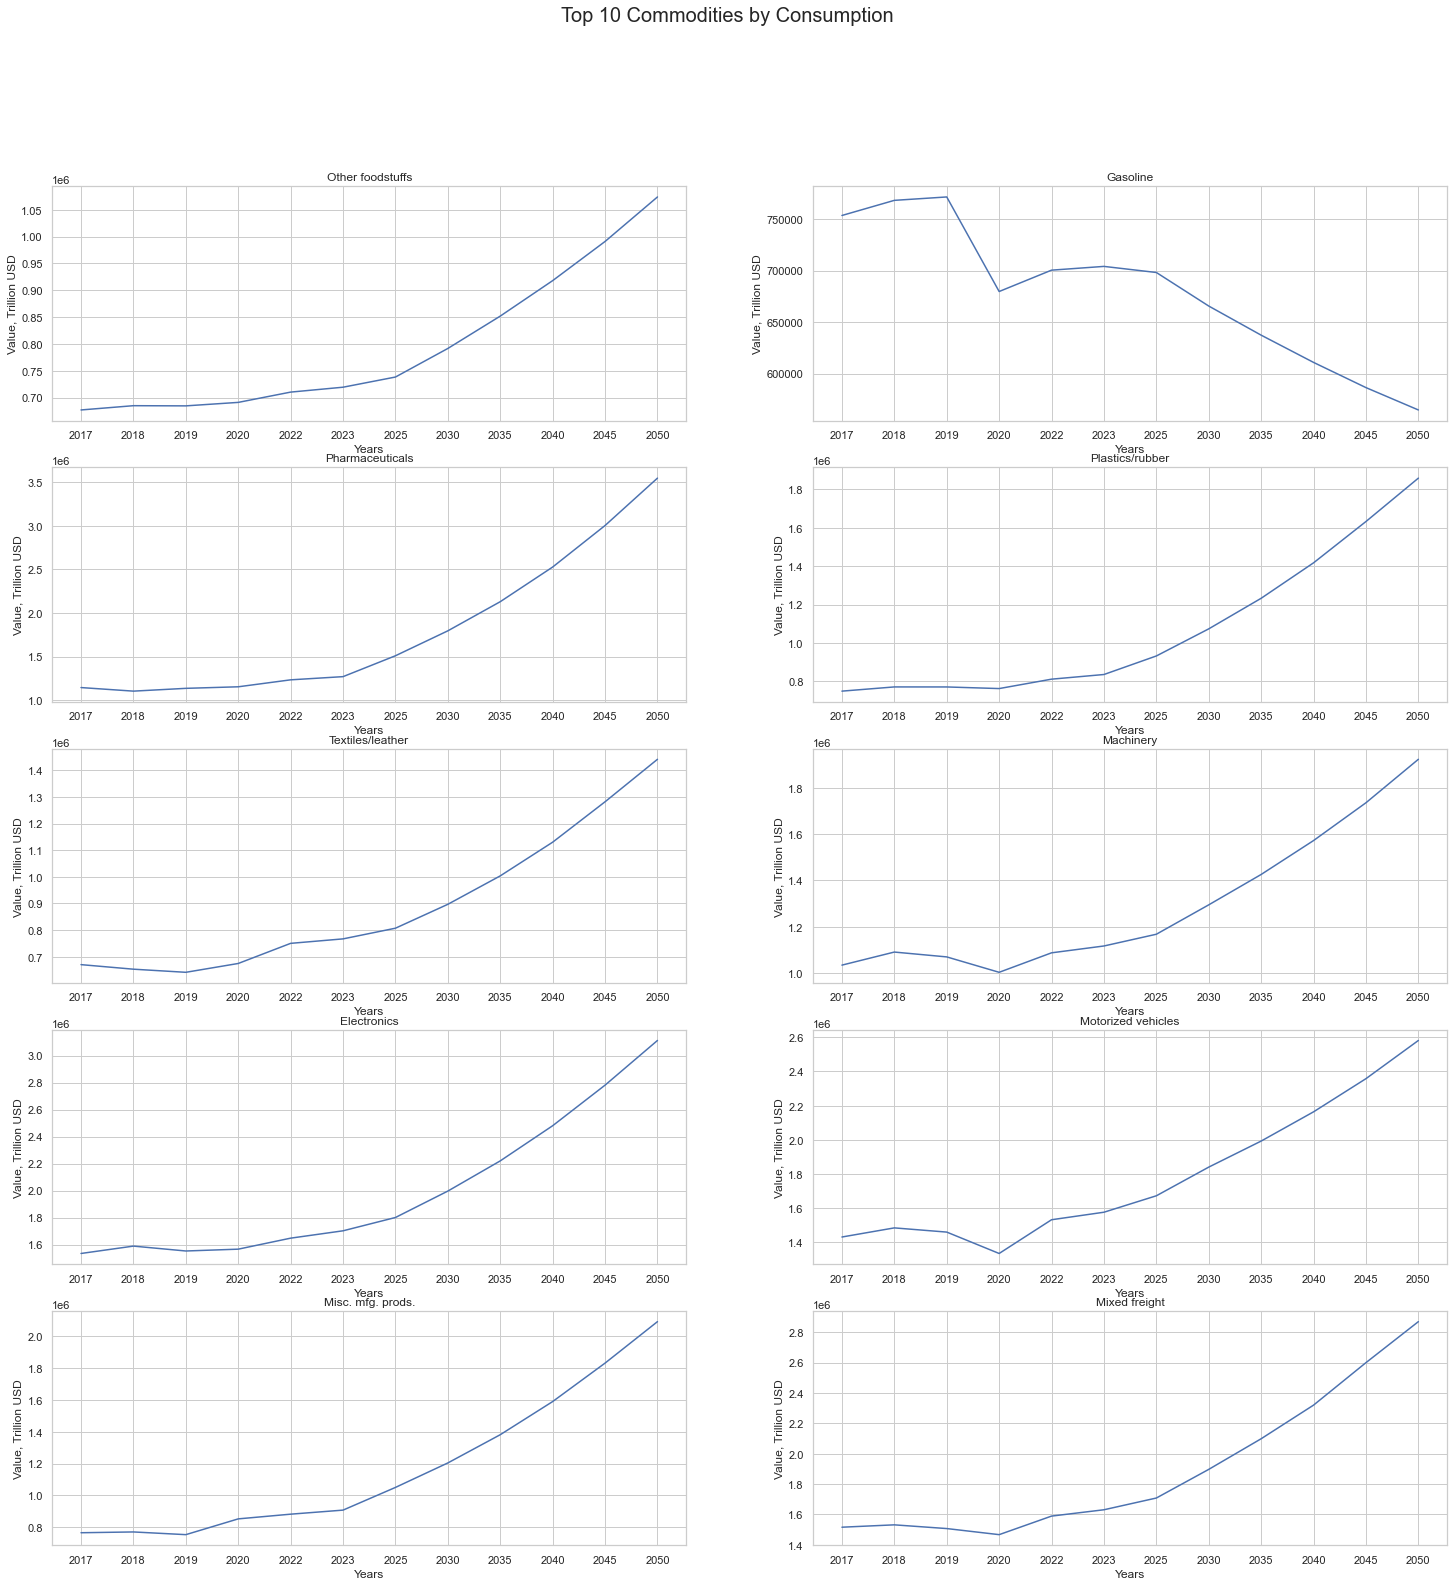

In [617]:
plotCommodities(top_dest_2017_2050, years, (5, 2), 'Top 10 Commodities by Consumption', "Years", "Value, Trillion USD")

### Analysis

Looking at the charts above, we see some really interesting trends.

Firstly, the trends of both production and consumption is the same. However, the amounts on the y-axis are different, which tell us that in some cases, there will be a deficit and in others there will be more production than consumption.

All charts trend upwards except Gasoline production and consumption. It looks like, with US adopting electric cars and relying more and more on renewable energy, gasoline usage will drop.

Another very interesting pattern we is is the COVID-dip in 2020. It's visible in almost all visualisations.

## Domestic and Internation
al Modes of Transportation

To get an understanding of what modes are used in the US, we can derive yearly data from the FAF5 dataset. For domestic, we use `dms_mode`, while for international `fr_inmode` and `fr_outmode` are used.

### Domestic Freight Modes

In [623]:
domesticYearsCols = ['dms_mode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

domestic_mode_df = regions_df[domesticYearsCols].groupby('dms_mode', as_index = False).sum()
domestic_mode_df.columns = ['dms_mode'] + years

# 8 is not domestic transportation mode so excluding it
domestic_mode_df = domestic_mode_df.loc[domestic_mode_df['dms_mode']!=8,]

domestic_mode_df[years] = domestic_mode_df[years].div(domestic_mode_df[years].sum(axis=0), axis=1).multiply(100)

### Foreign Freight Modes

In [620]:
# foreign fraight type (both import and export)
# domestic origin for export by value 2012-2045

frDestYearsCols = ['fr_outmode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']
frOrigYearsCols = ['fr_inmode','value_2017', 'value_2018', 'value_2019', 'value_2020', 'value_2022', 'value_2023',
 'value_2025', 'value_2030', 'value_2035', 'value_2040', 'value_2045', 'value_2050']

for_dest_df = regions_df.loc[pd.notnull(regions_df['fr_dest'])]
for_orig_df = regions_df.loc[pd.notnull(regions_df['fr_orig'])]

for_outmode_df = for_dest_df[frDestYearsCols].groupby('fr_outmode', as_index = True).sum()
for_inmode_df = for_orig_df[frOrigYearsCols].groupby('fr_inmode', as_index = True).sum()

for_mode_df = for_outmode_df.add(for_inmode_df) # add dfs

for_mode_df.reset_index(inplace = True)
for_mode_df.columns = ['for_mode'] + years

for_mode_df[years] = for_mode_df[years].div(for_mode_df[years].sum(axis=0), axis=1).multiply(100)

## Domestic and International Mode Plots

Text(0.5, 1.0, 'Domestic Modes')

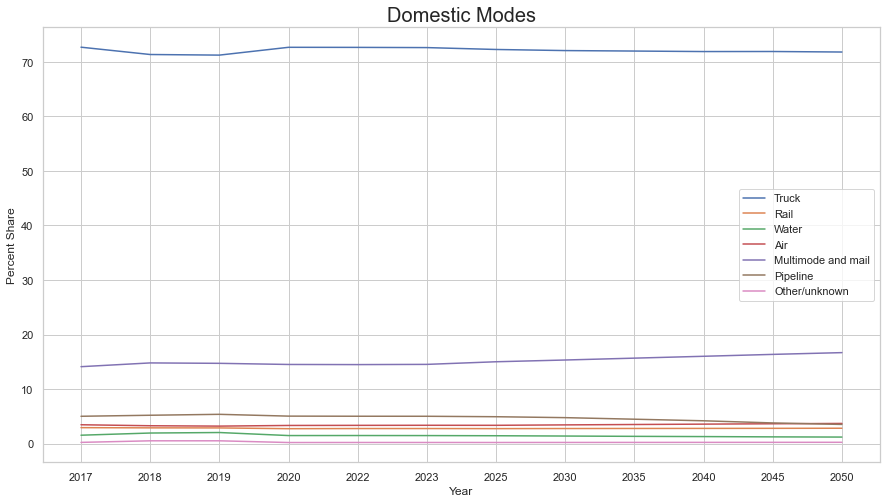

In [626]:
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

currMode = 0

for name in mode_list:
    ax.plot(domestic_mode_df.iloc[:, 1:13].columns, domestic_mode_df.iloc[currMode, 1:13],label=name)
    currMode = currMode + 1

ax.set_xlabel("Year")
ax.set_ylabel("Percent Share")
ax.legend(loc='best')
ax.set_title("Domestic Modes",fontsize=20)

Text(0.5, 1.0, 'International Modes')

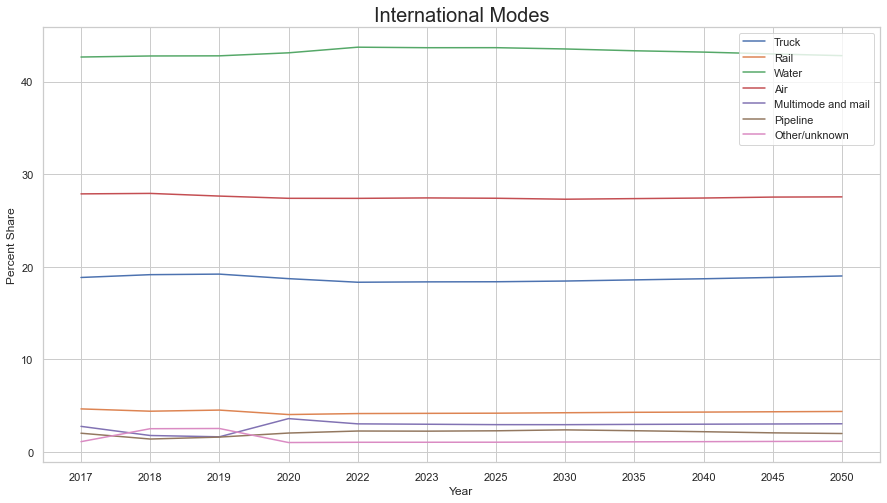

In [627]:
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

currMode = 0

for name in mode_list:
    ax.plot(for_mode_df.iloc[:, 1:13].columns, for_mode_df.iloc[currMode, 1:13],label=name)
    currMode = currMode + 1

ax.set_xlabel("Year")
ax.set_ylabel("Percent Share")
ax.legend(loc='best')
ax.set_title("International Modes",fontsize=20)

### Analysis

Both the domestic and international modes of transportation make sense.

For domestic, trucking is more common and takes up a major share. Air comes in next followed by other modes of transportation. For businesses targeting local shippers and freight forwarders, they need to focus on trucking and air first.

For international, Water or Ocean being the top one makes sense. This is followed by Air and then Trucking. One reason for trucking being an international mode for the US is that it borders with Canada and Mexico and there's a lot of freight that moves through those borders.

Since the static graphs have lines that are hard to distinguish, I ventured out to use plotly with a range slider for year.

## Modes of Transportation – Interactive Graph

In [631]:
currYears = ['2017','2018','2019','2020','2022','2023','2025','2030','2035','2040','2045','2050']
dfm = []
for year in currYears:
    dfn1 = for_mode_df[['for_mode', year]]
    dfn1.rename(columns={year:'Percent Share'}, inplace=True)
    dfn1['Year'] = year
    dfm.append(dfn1)
dfn = pd.concat(dfm)


def label_mode(row):
    mymode = mode_list[int(row['for_mode']) - 1]
    row['Mode'] = mymode
    return row

dfn = dfn.apply(label_mode, axis=1)

fig = px.bar(dfn, x='Mode', y='Percent Share', color='Mode',
                     animation_frame="Year", animation_group="Mode", title="International")
fig.show()

<ipython-input-631-3f881a467000>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [632]:
currYears = ['2017','2018','2019','2020','2022','2023','2025','2030','2035','2040','2045','2050']
dfm = []
for year in currYears:
    dfn1 = domestic_mode_df[['dms_mode', year]]
    dfn1.rename(columns={year:'Percent Share'}, inplace=True)
    dfn1['Year'] = year
    dfm.append(dfn1)
dfn = pd.concat(dfm)


def label_dmode(row):
    mymode = mode_list[int(row['dms_mode']) - 1]
    row['Mode'] = mymode
    return row

dfn = dfn.apply(label_dmode, axis=1)

fig = px.bar(dfn, x='Mode', y='Percent Share', color='Mode',
                     animation_frame="Year", animation_group="Mode", title="Domestic")
fig.show()

<ipython-input-632-eefeefa01450>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Analysis

The plotly charts show some interesting patterns because they are interactive.

For international, ocean/water freight's share decreases slightly and trucking freight increases over time. This means that the US will eventually trade more within America.

For domestic, pipeline's share decreasing which means that the US will rely more on renewable energy. Multimode and mail also increases over time.

## Air Freight – deep-drive

I wanted to analyse air freight some more so I got another dataset from Bureau of Transportation Statistics. This dataset provides an overview of the highest amount of landed freight.

### Import the dataset and view columns

In [633]:
adf = pd.read_csv('air_cargo.csv')
adf.columns

Index(['Airport Name', 'Year', 'City', 'Airport ID', 'Measure', 'Value'], dtype='object')

Let's see how many records do we have:

In [634]:
adf.shape

(1586, 6)

Let's see how many unique airports do we have

In [635]:
len(adf['Airport Name'].unique())

145

View first few records

In [637]:
adf.head()

,Airport Name,Year,City,Airport ID,Measure,Value
0,Memphis International,2000,Memphis,MEM,All-cargo operations landed weight (thousands ...,"6,318"
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,All-cargo operations landed weight (thousands ...,"8,084"
2,Louisville Muhammad Ali International,2000,Louisville,SDF,All-cargo operations landed weight (thousands ...,"3,987"
3,Miami International,2000,Miami,MIA,All-cargo operations landed weight (thousands ...,"2,929"
4,Los Angeles International,2000,Los Angeles,LAX,All-cargo operations landed weight (thousands ...,"2,892"


I'm also curious to see the number of years

In [638]:
len(adf['Year'].unique())

12

I want to see what values we have in the Measure column. We can remove it if it's 1 value because we probably won't need it.

In [639]:
len(adf['Measure'].unique())

1

In [640]:
adf = adf.drop('Measure', 1)
adf

,Airport Name,Year,City,Airport ID,Value
0,Memphis International,2000,Memphis,MEM,"6,318"
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,"8,084"
2,Louisville Muhammad Ali International,2000,Louisville,SDF,"3,987"
3,Miami International,2000,Miami,MIA,"2,929"
4,Los Angeles International,2000,Los Angeles,LAX,"2,892"
...,...,...,...,...,...
1581,William P Hobby,2020,Houston,HOU,0
1582,Ellington,2020,Houston,EFD,0
1583,Lakeland Linder International,2020,Lakeland,LAL,102
1584,Rochester International,2020,Rochester,RST,35


Let's see how many cities are included

In [641]:
len(adf['City'].unique())

136

Some minor cleaning: removing comma operator so that I can sort the Value column.

In [642]:
adf["Value"] = adf["Value"].replace(',','', regex=True)
adf["Value"] = pd.to_numeric(adf["Value"])

Just to get a rough idea, let's plot top 20 airports by cargo volume:

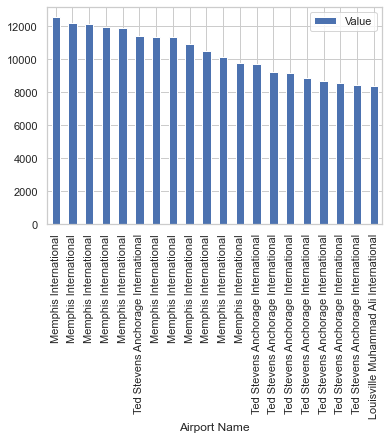

In [652]:
topTwenty = adf.sort_values(by=['Value'], ascending=False).head(20)
topTwenty[['Airport Name', 'Value']].plot(x="Airport Name", y="Value", kind = "bar")
plt.show()

As you can see, there is a lot of repitition. We'll probably want to have an yearly visualisation for top airports. And to plot them on the map, we'll need a database of coordinates.

I went ahead and downloaded one from the airport. It should be in the Git repo. Importing it here.

In [653]:
airportLocs = pd.read_csv('us-airports.csv')
airportLocs.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,3632,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,United States,US,...,Los Angeles,1,KLAX,LAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,1335475,2020-04-26T22:37:22+00:00
1,3754,KORD,large_airport,Chicago O'Hare International Airport,41.978600,-87.904800,672.0,NaN,United States,US,...,Chicago,1,KORD,ORD,ORD,https://www.flychicago.com/ohare/home/pages/de...,https://en.wikipedia.org/wiki/O'Hare_Internati...,"CHI, Orchard Place",1503175,2018-09-16T02:35:35+00:00
2,3622,KJFK,large_airport,John F Kennedy International Airport,40.639801,-73.778900,13.0,NaN,United States,US,...,New York,1,KJFK,JFK,JFK,https://www.jfkairport.com/,https://en.wikipedia.org/wiki/John_F._Kennedy_...,"Manhattan, New York City, NYC, Idlewild, IDL, ...",1052075,2021-11-21T19:43:08+00:00
3,3384,KATL,large_airport,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,1026.0,NaN,United States,US,...,Atlanta,1,KATL,ATL,ATL,http://www.atlanta-airport.com/,https://en.wikipedia.org/wiki/Hartsfield–Jacks...,NaN,2002475,2018-09-19T14:50:01+00:00
4,3878,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,United States,US,...,San Francisco,1,KSFO,SFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",1112475,2008-06-13T14:30:04+00:00


Now, to try out the plotly express's map visualisation and see if our coordinates work, I'll plot 1000 airports from head.

In [654]:
newdf = airportLocs.head(1000)
fig = px.scatter_geo(newdf,lat='latitude_deg',lon='longitude_deg', hover_name="name")
fig.update_layout(title = 'Some US Airports', title_x=0.5, geo = dict(
            scope='usa', projection_type='albers usa', showland = True))
fig.show()

### Function to map coordinates to airports

The following function and function call maps latitude & longitude to airport codes.

In [659]:
def addLatLng(row):
    mylat = airportLocs.loc[airportLocs['iata_code'] == row['Airport ID'], 'latitude_deg'].to_string(index=False)
    mylng = airportLocs.loc[airportLocs['iata_code'] == row['Airport ID'], 'longitude_deg'].to_string(index=False)
    
    mylat = re.sub(r'(\w+)(?=.*:)', 'http', mylat)
    mylng = re.sub(r'(\w+)(?=.*:)', 'http', mylng)
    row['Lat'] = mylat
    row['Lng'] = mylng
    return row

adf = adf.apply(addLatLng, axis=1)

In [660]:
adf2 = adf.groupby(['Airport ID','Year'], as_index=False)['Value'].sum()

In [664]:
adfSum = adf.groupby(['Airport ID', 'Airport Name'], as_index=False)['Value'].sum()

In [673]:
topFifty = adfSum.sort_values(by=['Value'], ascending=False).head(50)
topFifty = topFifty.apply(addLatLng, axis=1)

### Top Airports

To get the top airports by landed cargo, we'll need to sum all values by years and then plot it. Plotly's map plot is amazing because it lets me map marker size to the value.

In [675]:
fig = px.scatter_geo(topFifty,lat='Lat',lon='Lng', hover_name="Airport Name", size="Value")
fig.update_layout(title = 'Top Airports by Landed Cargo', title_x=0.5, geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ))

fig.show()

Even though the above visualisation gives us a high level understanding of landed cargo, but we still need to see trend over years to understand how it's changing.

To do that, we will need a slider for years. And separate top results per year.

In [678]:
adfYear2000 = adf.loc[adf['Year'] == 2000]
adfYear2010 = adf.loc[adf['Year'] == 2010]
adfYear2011 = adf.loc[adf['Year'] == 2011]
adfYear2012 = adf.loc[adf['Year'] == 2012]
adfYear2013 = adf.loc[adf['Year'] == 2013]
adfYear2014 = adf.loc[adf['Year'] == 2014]
adfYear2015 = adf.loc[adf['Year'] == 2015]
adfYear2016 = adf.loc[adf['Year'] == 2016]
adfYear2017 = adf.loc[adf['Year'] == 2017]
adfYear2018 = adf.loc[adf['Year'] == 2018]
adfYear2019 = adf.loc[adf['Year'] == 2019]
adfYear2020 = adf.loc[adf['Year'] == 2020]

In [679]:
getTopNum = 50
allFrames = [adfYear2000.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2010.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2011.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2012.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2013.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2014.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2015.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2016.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2017.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2018.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2019.sort_values(by=['Value'], ascending=False).head(getTopNum),
             adfYear2020.sort_values(by=['Value'], ascending=False).head(getTopNum)]
topCargoAirports = pd.concat(allFrames)

In [680]:
topCargoAirports

,Airport Name,Year,City,Airport ID,Value,Lat,Lng
1,Ted Stevens Anchorage International,2000,Anchorage,ANC,8084.0,61.1744,-149.996002
0,Memphis International,2000,Memphis,MEM,6318.0,35.0424,-89.9767
2,Louisville Muhammad Ali International,2000,Louisville,SDF,3987.0,38.1744,-85.736
3,Miami International,2000,Miami,MIA,2929.0,25.7932,-80.290604
4,Los Angeles International,2000,Los Angeles,LAX,2892.0,33.942501,-118.407997
...,...,...,...,...,...,...,...
1487,Albuquerque International Sunport,2020,Albuquerque,ABQ,304.0,35.040199,-106.609001
1488,Sacramento Mather,2020,Sacramento,MHR,299.0,38.553902,-121.297997
1483,General Mitchell International,2020,Milwaukee,MKE,298.0,42.947201,-87.896599
1485,Kansas City International,2020,Kansas City,MCI,298.0,39.2976,-94.713898


In [681]:
fig = px.scatter_geo(topCargoAirports,lat='Lat',lon='Lng', hover_name="Airport Name", size="Value",
                     animation_frame="Year", animation_group="Airport Name")
fig.update_layout(title = 'Top Airports for Freight', title_x=0.5, geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ))

fig.show()